# Simple one-way ANOVA 
- 07/28/2022
- HILICpos
- TIC normalized dataset

# load library

In [45]:
# Let the middle rows included.
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)

In [46]:
library(dplyr)
library(car)
library(glue)
source("../utilis/utilis.R") # merge_by_rowName

## Read data table

In [47]:
exp_label = 'PS_speciesOnly_hMinImp_TICnorm_groupFil0.3_HILICpos'

In [48]:
feat_df = read.csv("../../../output/preprocessing_on_targetd28/putative_PS_species_FC_log2_hMinImp_TICnorm_groupFil0.3_HILICpos_featab.csv", row.names = 1)

In [49]:
head(feat_df)

,mz,rtime,rtime_left_base,rtime_right_base,parent_masstrack_id,peak_area,cSelectivity,goodness_fitting,snr,detection_counts,Naive_percNA,Naive_mean,R5neg_percNA,R5neg_mean,R5pos_percNA,R5pos_mean,gMean_Naive,gMean_R5neg,gMean_R5pos,log2FC_R5negvsNaive,log2FC_R5posvsNaive,log2FC_R5posvsR5neg,Naive_1,Naive_2,Naive_3,R5neg_1,R5neg_2,R5neg_3,R5pos_1,R5pos_2,R5pos_3,nist,q3June2014_1,q3June2014_2
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F10769,372.7447,25.17,23.59,28.32,9930,2649961,1,0.99,456,5,0.3333333,607321,0,814311.7,1.0000000,NA,18.87393,19.87924,18.18448,1.00530733,-0.689451593,-1.6947589,19.18448,19.25283,18.18448,19.42996,20.42619,19.78156,18.18448,18.18448,18.18448,NA,NA,NA
F11541,384.7631,38.83,36.20,41.72,10150,748661750,1,0.97,86549,22,0.0000000,38240480,0,15914575.0,0.0000000,51969739,25.08034,24.22063,25.29502,-0.85970886,0.214678350,1.0743872,25.47994,24.98491,24.77617,24.17855,24.45577,24.02758,25.23576,25.45258,25.19671,25.99780,25.03423,25.0114
F13199,548.3007,24.64,22.28,27.79,12591,124579197,1,0.87,7880,13,0.0000000,18878581,0,14459066.7,0.0000000,24287771,24.06018,24.08319,24.05723,0.02300941,-0.002942386,-0.0259518,24.08338,24.45670,23.64044,24.37743,23.83728,24.03485,22.91200,24.82122,24.43848,16.85336,NA,NA
F13675,557.3588,25.43,23.59,28.32,12697,4217228,1,0.97,587,6,1.0000000,NA,0,1002160.7,0.3333333,1337436,18.72961,20.24748,19.62756,1.51786475,0.897943497,-0.6199213,18.72961,18.72961,18.72961,20.27951,20.12174,20.34119,18.72961,19.72961,20.42344,NA,NA,NA
F13861,486.2846,25.95,24.38,28.84,11788,3788049,1,0.84,363,5,0.6666667,610026,0,1308415.7,0.6666667,1049975,18.55184,20.54879,18.73663,1.99694951,0.184788115,-1.8121614,18.21851,19.21851,18.21851,19.84244,20.70139,21.10255,18.21851,19.77288,18.21851,NA,NA,NA
F14458,571.3745,25.69,23.59,28.84,12860,57656484,1,0.89,6250,12,0.0000000,6641773,0,6248091.5,0.0000000,9920116,22.52329,22.87460,22.89693,0.35131175,0.373643249,0.0223315,22.18899,22.59417,22.78670,22.89830,23.05746,22.66804,22.39844,23.13912,23.15323,NA,NA,NA


##### Check the data, make sure it is already log2-transformed

In [50]:
data.df.log2 = feat_df[,grep('Naive\\_[0-9]+|R5[a-z]+\\_[0-9]+',colnames(feat_df))]

## Read metadata

In [51]:
meta_df = read.csv("../../../input/sequence_file/clean_meta_df_wt1_HILICpos.csv", row.names = 1)

In [52]:
# since the meta_df originally have techincal replicates, which is not unique after technical replicate summaries
# Thus processing metadata a little bit to retain only relevant rows
sub_meta_df <- meta_df[c('tID_dedup','class','biological_samples','cell_number')]
sub_meta_df <- unique(sub_meta_df)

rownames(sub_meta_df) = sub_meta_df$tID_dedup
sub_meta_df = sub_meta_df[colnames(data.df.log2),]
meta_df = sub_meta_df

In [53]:
write.csv(meta_df,"../../../input/sequence_file/clean_deduplicated_meta_df.csv", row.names = FALSE)

------

# Summary
- check if the metadata & data matched (It should be as they have been filtered in the last notebook)
- check key metadata

In [54]:
nrow(meta_df) == ncol(data.df.log2)

[1] TRUE

In [55]:
table(meta_df['class'])

class
Naive R5neg R5pos 
    3     3     3 

### Transpose the table and prepare to merge with meta data

In [56]:
data_df.t = t(data.df.log2) # transpose the table

In [57]:
data_df.t[1:5,1:5]

,F10769,F11541,F13199,F13675,F13861
Naive_1,19.18448,25.47994,24.08338,18.72961,18.21851
Naive_2,19.25283,24.98491,24.45670,18.72961,19.21851
Naive_3,18.18448,24.77617,23.64044,18.72961,18.21851
R5neg_1,19.42996,24.17855,24.37743,20.27951,19.84244
R5neg_2,20.42619,24.45577,23.83728,20.12174,20.70139


In [58]:
ft_names = colnames(data_df.t);ft_names[1:5]

[1] "F10769" "F11541" "F13199" "F13675" "F13861"

In [59]:
meta_df[1:5,]

,tID_dedup,class,biological_samples,cell_number
,<chr>,<chr>,<chr>,<int>
Naive_1,Naive_1,Naive,Yes,300
Naive_2,Naive_2,Naive,Yes,300
Naive_3,Naive_3,Naive,Yes,300
R5neg_1,R5neg_1,R5neg,Yes,655
R5neg_2,R5neg_2,R5neg,Yes,687


----

------

# Simple one-way ANOVA
- Run all gated populations
- `ft_names`

## Prepare for the table

In [60]:
prep4anova_df = merge_by_rowName(data_df.t, meta_df) # merge data table and metadata

In [61]:
prep4anova_df_filt <- prep4anova_df[,c(
    colnames(prep4anova_df)[colnames(prep4anova_df) %in% ft_names], # ft_names
    c('class') # + critical study design factors
)] # select the columns

In [62]:
prep4anova_df_filt[1:9,c(ncol(prep4anova_df_filt)-1, ncol(prep4anova_df_filt))]

,F18900,class
,<dbl>,<chr>
Naive_1,16.79993,Naive
Naive_2,17.65322,Naive
Naive_3,16.35093,Naive
R5neg_1,15.13238,R5neg
R5neg_2,17.63214,R5neg
R5neg_3,17.01757,R5neg
R5pos_1,13.62873,R5pos
R5pos_2,15.36516,R5pos
R5pos_3,14.20427,R5pos


## Run ANOVA

In [63]:
anova_res_list <- lapply(prep4anova_df[,ft_names], function(x) {
    return(tryCatch(
        aov(x ~ prep4anova_df[,'class']), # no var.equal as the argument will be disregarded.
        error=function(e) NULL))
})

## Wrap ANOVA result into table

In [64]:
anova_res_list2table <- function(anova_res_list = anova_res_list,
                                 name_of_variable = "FTID") {
    # Turn one-way Anova result into table
    temp_row_list <- list()
    for (i in 1:length(anova_res_list)) {
      if(is.null(anova_res_list[[i]])) {
        temp_row_list[[i]] <- data.frame(names(anova_res_list[i]),0,1) # If Null, f-score =0, pval = 1' somehow names should be using single bracket []
        colnames(temp_row_list[[i]]) <- c(name_of_variable,"f_score","pval")
      } else {
        anova_res.summary <- summary(anova_res_list[[i]])
        temp_row_list[[i]] <- data.frame(names(anova_res_list[i]), anova_res.summary[[1]]['F value'][[1]][1], anova_res.summary[[1]]['Pr(>F)'][[1]][1])
        colnames(temp_row_list[[i]]) <- c(name_of_variable,"f_score","pval")
      }
    }
    anova_res_df = do.call(rbind, temp_row_list)
    anova_res_df$padj <- p.adjust(anova_res_df$pval, method = 'BH') 

    anova_res_df = data.frame(anova_res_df)
    rownames(anova_res_df) = anova_res_df[,1]
    anova_res_df = anova_res_df[,2:ncol(anova_res_df)]
    return(anova_res_df)
}

#### debugging run

In [65]:
# anova_res_df = anova_res_list2table(anova_res_list, "featureID")
# dim(anova_res_df) # the dimension should be the same with original table

## Run tukey test on the `anova_res_list`

In [66]:
anova_res_list2tukeytest_table <- function(anova_res_list = anova_res_list,
                                 name_of_variable = "FTID") {
    # Perform tukey test and generate the table from anova result list
    # Also current function only deals with one variable, for 2-way anova or multivariate regression, this function cannot implement
    temp_row_list <- list()
    
    # search for a valid result to get template for set up the NA stuffs
    for (i in 1:length(anova_res_list)) {
      if(!is.null(anova_res_list[[i]])) {
        tukey.test <- TukeyHSD(anova_res_list[[i]])
        
        obj_list = ls(tukey.test) # There will only be one if it is 1-way anova
        obj = obj_list[[1]]
        
        tukey_oriTab = tukey.test[[obj]]
        
        padj_col_names = paste0('Tpadj_',rownames(tukey_oriTab))
        colnames = c(name_of_variable,padj_col_names)
        
        length = dim(tukey_oriTab)[1]
        
        break
        }
    } 
    
    # then go for the real run
    for (i in 1:length(anova_res_list)) {
      if(!is.null(anova_res_list[[i]])) {
        tukey.test <- TukeyHSD(anova_res_list[[i]])
        tukey_oriTab = tukey.test[[obj]]
        temp_row_list[[i]] <- c(names(anova_res_list[i]), 
                                tukey_oriTab[,4] )
        } 
        else 
        {
        temp_row_list[[i]] <- c(names(anova_res_list[i]),
                                rep(NA,length) ) # If Null, f-score =0, pval = 1' somehow names should be using single bracket []
        
      }
    }
    tukey_res_df = do.call(rbind, temp_row_list)
    colnames(tukey_res_df) = colnames
    
    # handling the fickled things about numeric
    tukey_res_df = data.frame(tukey_res_df)
    rownames = tukey_res_df[,1]
    tukey_res_df = tukey_res_df[,2:ncol(tukey_res_df)]
    tukey_res_df = sapply(tukey_res_df, as.numeric)
    tukey_res_df = data.frame(tukey_res_df)
    rownames(tukey_res_df) = rownames
    
    # correction of Tukey post-hoc stat as well
    Tpadj_cols = colnames(tukey_res_df)[grepl('Tpadj',colnames(tukey_res_df))]
    for (Tpadj_col in Tpadj_cols) {
        tukey_res_df[,gsub('Tpadj','TFDR',Tpadj_col)] <- p.adjust(tukey_res_df[,Tpadj_col], method = 'BH')
    }

    
    # For tukey test, no need to do another round of FDR
    return(tukey_res_df)
}

#### debugging run

In [67]:
# tukey_res_df = anova_res_list2tukeytest_table(anova_res_list,"featureID")

# dim(tukey_res_df)

# aov_tuk_df = merge(anova_res_df,tukey_res_df, by.x = 0, by.y = 0)

# # check if rownames of both table to be merged is the same
# all((rownames(tukey_res_df) == rownames(anova_res_df)) == TRUE)

# dim(aov_tuk_df)
# colnames(aov_tuk_df)

# Wrapper function

In [68]:
oneway_anova_tukey_analysis <- function(data_df = data_df.t,
                                     meta_df = meta_df,
                                     name_of_class = 'class',
                                     name_of_variable = 'featureID') {
    # always observations as rows, subjects as columns
    # Here only suports 1-way anova which has only one variable
    
    prep4anova_df = merge_by_rowName(data_df, meta_df) # merge data table and metadata
    ft_names = colnames(data_df)
    prep4anova_df_filt <- prep4anova_df[,c(
        colnames(prep4anova_df)[colnames(prep4anova_df) %in% ft_names], # ft_names
        name_of_class)] # select the columns
    
    anova_res_list <- lapply(prep4anova_df[,ft_names], function(x) {
                        return(tryCatch(
                            aov(x ~ prep4anova_df[,name_of_class]), # no var.equal as the argument will be disregarded.
                            error=function(e) NULL))
                        })
    anova_res_df = anova_res_list2table(anova_res_list, name_of_variable)
    tukey_res_df = anova_res_list2tukeytest_table(anova_res_list, name_of_variable)
    
    # check if rownames of both table to be merged is the same
    msg_check_rowName = all((rownames(tukey_res_df) == rownames(anova_res_df)) == TRUE)
    print(glue('Row name of ANOVA & tukeyTest table is the same? :{msg_check_rowName}'))                           
    
    aov_tuk_df = merge_by_rowName(anova_res_df,tukey_res_df)

    return(aov_tuk_df) # debug: list(anova_res_df,tukey_res_df)
}

In [69]:
aov_tuk_df <- oneway_anova_tukey_analysis(data_df = data_df.t,
                            meta_df = meta_df,
                            name_of_class = 'class',
                            name_of_variable = 'featureID')


Row name of ANOVA & tukeyTest table is the same? :TRUE


In [70]:
head(aov_tuk_df)

,f_score,pval,padj,Tpadj_R5neg.Naive,Tpadj_R5pos.Naive,Tpadj_R5pos.R5neg,TFDR_R5neg.Naive,TFDR_R5pos.Naive,TFDR_R5pos.R5neg
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F10769,10.665303620,0.010580493,0.04520756,0.07683568,0.2276851,0.008865051,0.24476873,0.6820729,0.03787795
F11541,14.781111902,0.004802717,0.02508086,0.01480787,0.5886961,0.005142230,0.09942426,0.8646473,0.02420651
F13199,0.001440125,0.998561256,0.99856126,0.99895988,0.9999830,0.998677101,0.99895988,1.0000000,0.99867710
F13675,7.103773875,0.026176580,0.05672360,0.02224461,0.1463886,0.342844709,0.13068706,0.6520000,0.40284253
F13861,7.055995090,0.026551472,0.05672360,0.03347616,0.9473926,0.049005113,0.17481994,1.0000000,0.09212961
F14458,1.243703167,0.353287904,0.38615189,0.43481961,0.3959534,0.996117395,0.65924263,0.7443924,0.99867710


In [71]:
colnames(aov_tuk_df)

[1] "f_score"           "pval"              "padj"             
[4] "Tpadj_R5neg.Naive" "Tpadj_R5pos.Naive" "Tpadj_R5pos.R5neg"
[7] "TFDR_R5neg.Naive"  "TFDR_R5pos.Naive"  "TFDR_R5pos.R5neg"

In [72]:
dim(aov_tuk_df)

[1] 47  9

----

In [73]:
histogram_p <- function(stat_df,p_label, title_label) {
    par(mar=c(10,5,4,1))
    par(mfrow=c(2,2))
    pval_col_list = colnames(stat_df)[grepl(p_label, colnames(stat_df), fixed=TRUE)]
    print(pval_col_list)
    for (pval_col in pval_col_list) {
        hist(stat_df[,pval_col],
             col = 'skyblue3', 
             breaks = 20, 
             xlab=pval_col, 
             main=paste0(title_label,'\n',gsub(p_label,'',pval_col)))
    }
}

[1] "padj"              "Tpadj_R5neg.Naive" "Tpadj_R5pos.Naive"
[4] "Tpadj_R5pos.R5neg"


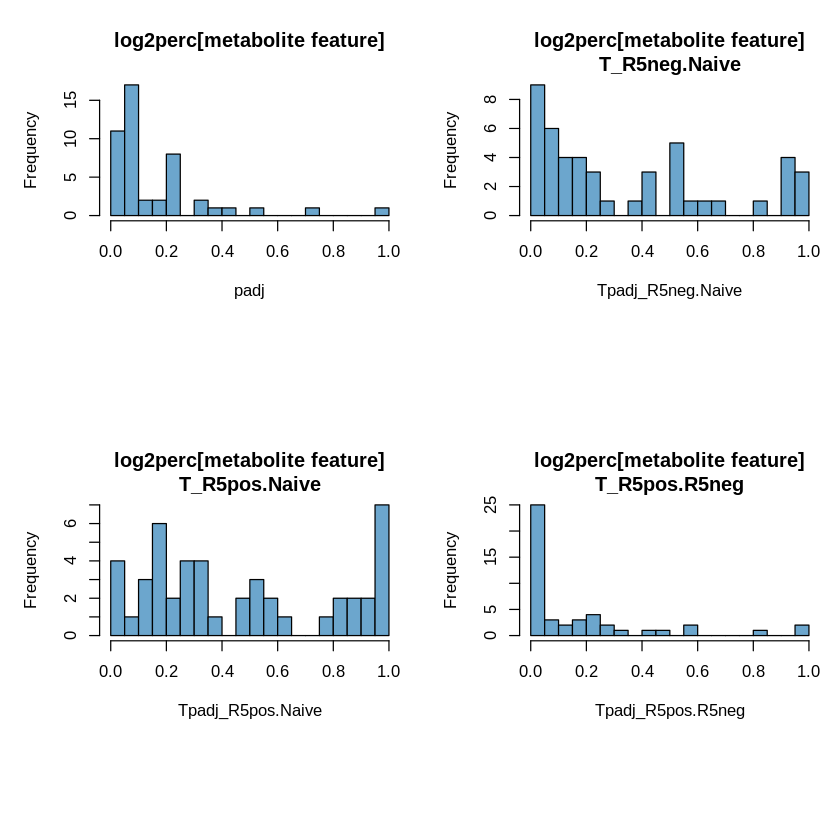

In [74]:
histogram_p(aov_tuk_df,'padj','\nlog2perc[metabolite feature]')

[1] "TFDR_R5neg.Naive" "TFDR_R5pos.Naive" "TFDR_R5pos.R5neg"


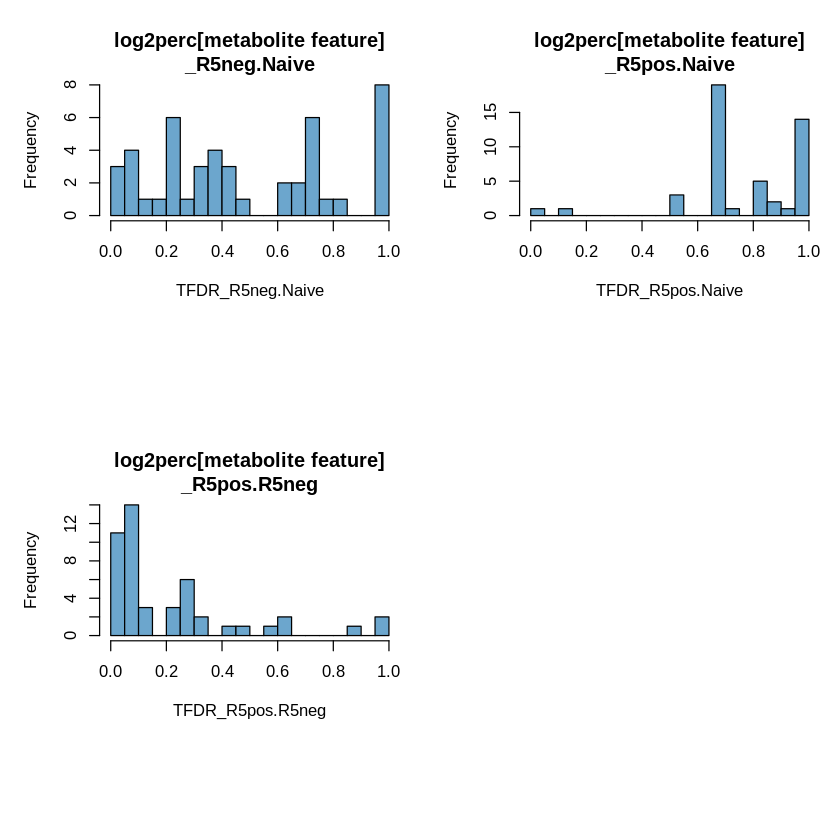

In [75]:
histogram_p(aov_tuk_df,'TFDR','\nlog2perc[metabolite feature]')

[1] "pval"


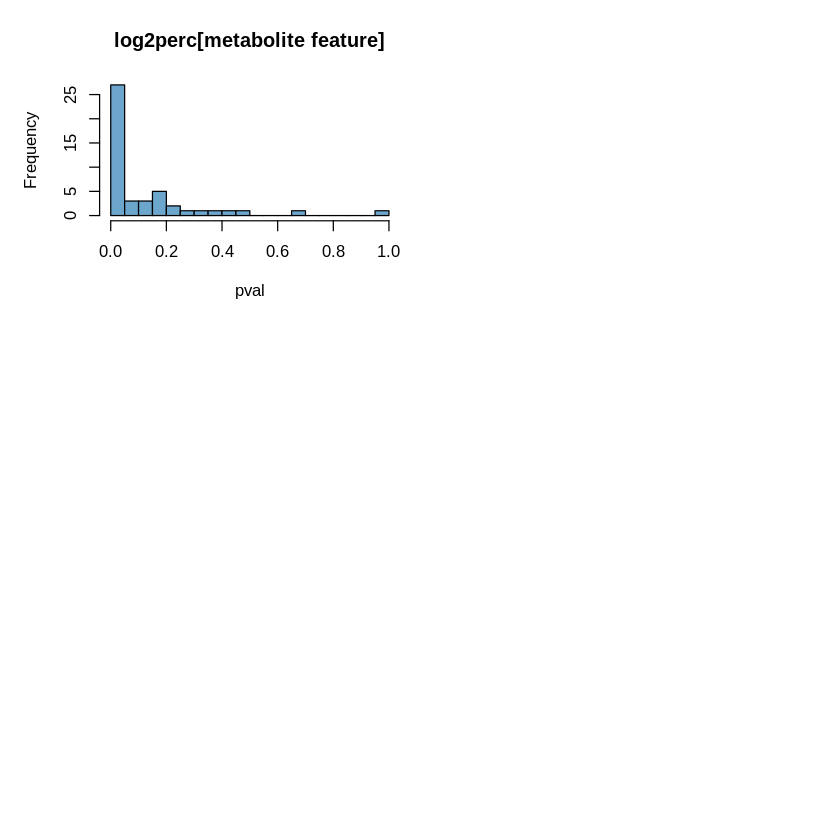

In [76]:
histogram_p(aov_tuk_df,'pval','\nlog2perc[metabolite feature]')

In [77]:
colnames(aov_tuk_df)

[1] "f_score"           "pval"              "padj"             
[4] "Tpadj_R5neg.Naive" "Tpadj_R5pos.Naive" "Tpadj_R5pos.R5neg"
[7] "TFDR_R5neg.Naive"  "TFDR_R5pos.Naive"  "TFDR_R5pos.R5neg"

In [78]:
sign_df = aov_tuk_df[(aov_tuk_df$padj < 0.05),]
sign_df[1:10,]

,f_score,pval,padj,Tpadj_R5neg.Naive,Tpadj_R5pos.Naive,Tpadj_R5pos.R5neg,TFDR_R5neg.Naive,TFDR_R5pos.Naive,TFDR_R5pos.R5neg
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F10769,10.66530,1.058049e-02,0.0452075614,7.683568e-02,0.2276850594,8.865051e-03,0.2447687295,0.68207294,0.0378779460
F11541,14.78111,4.802717e-03,0.0250808567,1.480787e-02,0.5886960594,5.142230e-03,0.0994242620,0.86464734,0.0242065071
F16361,18.69664,2.643543e-03,0.0155308140,7.288438e-02,0.0359219848,2.133279e-03,0.2447687295,0.50897777,0.0143234474
F17371,18.79918,2.606414e-03,0.0155308140,7.257349e-03,0.6466582679,3.014013e-03,0.0682190812,0.92099814,0.0177073264
F17442,13.26469,6.275188e-03,0.0294933853,6.094829e-02,0.1446012553,5.150321e-03,0.2447687295,0.65200001,0.0242065071
F17621,229.70605,2.142598e-06,0.0001007021,3.554909e-06,1.0000000000,3.554909e-06,0.0001670807,1.00000000,0.0001670807
F17672,114.18127,1.677989e-05,0.0003943275,3.983891e-05,0.5290062657,2.384129e-05,0.0009362143,0.84110684,0.0005602704
F18429,32.48206,6.044176e-04,0.0071019072,1.049010e-03,1.0000000000,1.049010e-03,0.0164344832,1.00000000,0.0093634819
F18473,79.47040,4.813594e-05,0.0007541297,9.188080e-03,0.0005340464,4.028133e-05,0.0719732902,0.02510018,0.0006310742


In [79]:
dim(aov_tuk_df[aov_tuk_df$padj < 0.05,])[1]

[1] 11

In [80]:
dim(aov_tuk_df[aov_tuk_df$padj < 0.1,])[1]

[1] 28

In [81]:
dim(aov_tuk_df[aov_tuk_df$pval < 0.05,])[1] # check raw p value

[1] 27

-------

----

# construct the final result tables

In [82]:
detect_boundary_index = function(feat_df = feat_df,
                                 Data_RegExpr = '\\_[0-9]+'
                                ) {
    # the output index is the last index for the metainfo
    first_index4data = grep(Data_RegExpr,colnames(feat_df))[1]
    # range = colnames(feat_df)[first_index4data - 1:first_index4data + 1]
    print(colnames(feat_df)[first_index4data-1])
    return(first_index4data-1)
}

In [83]:
wrap_res2ful <- function(aov_tuk_df = aov_tuk_df,
                         feat_df = feat_df,
                         end_index = metainfo_end_index) {
    metainfo_df = feat_df[,1:end_index]
    metainfo_df = merge_by_rowName(metainfo_df,aov_tuk_df) # use merge by rowname in utilis
    m_df = merge_by_rowName(metainfo_df,
                 feat_df[(end_index + 1):ncol(feat_df)]) # use merge by rowname in utilis
    return(m_df)
}
    

In [84]:
metainfo_end_index = detect_boundary_index(feat_df = feat_df, 
                                           Data_RegExpr = '\\_[0-9]+')
full_res_df <- wrap_res2ful(aov_tuk_df = aov_tuk_df,
                         feat_df = feat_df,
                         end_index = metainfo_end_index)

[1] "log2FC_R5posvsR5neg"


In [85]:
dim(full_res_df)

[1] 47 43

In [86]:
colnames(full_res_df)

[1] "mz"                  "rtime"               "rtime_left_base"    
 [4] "rtime_right_base"    "parent_masstrack_id" "peak_area"          
 [7] "cSelectivity"        "goodness_fitting"    "snr"                
[10] "detection_counts"    "Naive_percNA"        "Naive_mean"         
[13] "R5neg_percNA"        "R5neg_mean"          "R5pos_percNA"       
[16] "R5pos_mean"          "gMean_Naive"         "gMean_R5neg"        
[19] "gMean_R5pos"         "log2FC_R5negvsNaive" "log2FC_R5posvsNaive"
[22] "log2FC_R5posvsR5neg" "f_score"             "pval"               
[25] "padj"                "Tpadj_R5neg.Naive"   "Tpadj_R5pos.Naive"  
[28] "Tpadj_R5pos.R5neg"   "TFDR_R5neg.Naive"    "TFDR_R5pos.Naive"   
[31] "TFDR_R5pos.R5neg"    "Naive_1"             "Naive_2"            
[34] "Naive_3"             "R5neg_1"             "R5neg_2"            
[37] "R5neg_3"             "R5pos_1"             "R5pos_2"            
[40] "R5pos_3"             "nist"                "q3June2014_1"       
[43] "q3June2014_2"

## output

In [89]:
output_fdr = glue('../../../output/{exp_label}_1wayANOVA/')
dir.create(output_fdr)

In [90]:
write.csv(full_res_df,
          file.path(output_fdr, 
                    glue('one_wayANOVA_{exp_label}_fullreport.csv')))

------

In [91]:
col_stat_score = colnames(feat_df)[grep('log2FC',colnames(feat_df))]

In [92]:
col_stat_score

[1] "log2FC_R5negvsNaive" "log2FC_R5posvsNaive" "log2FC_R5posvsR5neg"

In [93]:
col_padj_stat = colnames(aov_tuk_df)[grep('Tpadj',colnames(aov_tuk_df))]

In [94]:
col_padj_stat

[1] "Tpadj_R5neg.Naive" "Tpadj_R5pos.Naive" "Tpadj_R5pos.R5neg"

In [95]:
grepl('R5neg(\\.|vs)Naive',col_padj_stat)

[1]  TRUE FALSE FALSE

In [96]:
contrast_regExprs = c('R5neg(\\.|vs)Naive',
                      'R5pos(\\.|vs)Naive',
                      'R5pos(\\.|vs)R5neg')

res2mcg_tukey <- function(full_res_df = full_res_df,
                         contrast_regExprs = contrast_regExprs,
                         padj_label = 'TFDR',
                         stat_label = 'log2FC',
                         output_fdr = output_fdr) {
    # Use log2FC as stat and padj/TFDR from tukey test for p cutoff
    for (regExpr in contrast_regExprs) {
        coln = colnames(full_res_df)
        padj_col = coln[grep(glue("{padj_label}\\_{regExpr}"),coln)]
        stat_col = coln[grep(glue("{stat_label}\\_{regExpr}"),coln)]
        mcg_df = full_res_df[c('mz','rtime',padj_col,stat_col,'padj')]
        mcg_df['id_number'] = rownames(full_res_df)
        
        true_label = strsplit(stat_col,'_')[[1]][2]
        write.table(mcg_df,
          file.path(output_fdr, 
                    glue('{true_label}_{exp_label}_{padj_label}_4mcg.txt')),
                    sep = '\t',
                    row.names = FALSE)

    }
        
}

In [97]:
res2mcg_tukey(full_res_df = full_res_df,
                         contrast_regExprs = contrast_regExprs,
                         padj_label = 'TFDR', # using tukey FDR instead
                         stat_label = 'log2FC',
                         output_fdr = output_fdr)

## 2-steps to control tukey stat


In [98]:
res2mcg_tukey_2steps <- function(full_res_df = full_res_df,
                         contrast_regExprs = contrast_regExprs,
                         padj_label = 'Tpadj',
                         stat_label = 'log2FC',
                         output_fdr = output_fdr) {
    # With 2 steps, the data go after Tpadj, 
    # but turn to 1 if the feature didn't pass the 1-way ANOVA FDR
    # Use log2FC as stat and padj from tukey test for p cutoff
    
    for (regExpr in contrast_regExprs) {
        coln = colnames(full_res_df)
        padj_col = coln[grep(glue("{padj_label}\\_{regExpr}"),coln)]
        stat_col = coln[grep(glue("{stat_label}\\_{regExpr}"),coln)]
        mcg_df = full_res_df[c('mz','rtime',padj_col,stat_col,'padj')]
        mcg_df['id_number'] = rownames(full_res_df)
        
        true_label = strsplit(stat_col,'_')[[1]][2] # just quick way to get the contrast
        
        mcg_df[glue("org_{padj_col}")] = mcg_df[padj_col]
        mcg_df[mcg_df$padj > 0.05, padj_col] = 1
        
        write.table(mcg_df,
          file.path(output_fdr, 
                    glue('{true_label}_{exp_label}_{padj_label}_2steps_4mcg.txt')),
                    sep = '\t',
                    row.names = FALSE)

    }
        
}

In [99]:
res2mcg_tukey_2steps(full_res_df = full_res_df,
                         contrast_regExprs = contrast_regExprs,
                         padj_label = 'Tpadj', # using tukey FDR instead
                         stat_label = 'log2FC',
                         output_fdr = output_fdr)

------

## Summary: normal one-way ANOVA
- with Tukey post-hoc test
- Run through all the contrast